In [0]:
from fastai import *
from fastai.text import *
from pathlib import Path
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re

In [0]:
def clean_ascii(text):
    # function to remove non-ASCII characters from data
    return ''.join(i for i in text if ord(i) < 128)

In [0]:
# path to training files
trainfile = 'data.csv'

In [0]:
# read csv into dataframe
train_data = pd.read_csv(trainfile, delimiter='\t', header=None, encoding = "latin-1")
train_data.columns =["Tid","Tweet", "Label"] # assing column names

train_data.drop('Tid', axis=1, inplace=True) # remove TweetId column

train_data['Label'] = train_data['Label'].str.strip() # remove whitespaces from class labels

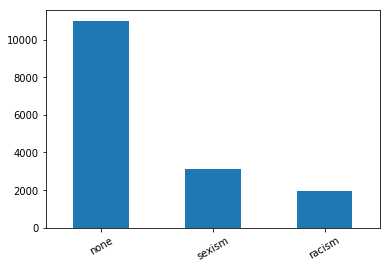

In [0]:
# Plot value counts for rach class in the dataset
train_data['Label'].value_counts().plot.bar(rot=30);

In [0]:
# data cleaning and overview
train_data['Tweet'] = train_data['Tweet'].apply(clean_ascii)

train_data.head()

,Tweet,Label
0,RT @colonelkickhead: Another bloody instant re...,none
1,@azzamalirhabi @JihadiA8 This video of the Pes...,none
2,Oh really? No more instant restaurants? THAT'S...,none
3,RT @Benfrancisallen: It hasn't been a good few...,none
4,RT @NoToFeminism: I dont need femisnsn because...,none


In [0]:
#ULMFit requires just the label and the text data (i.e. tweets) for the language-model finetuning & classification 
train_temp = pd.concat([train_data['Label'], train_data['Tweet']], axis=1)
train_temp.tail()

,Label,Tweet
16045,sexism,"RT @MyDearWormwood: ""I want equal rights, but ..."
16046,sexism,RT @alexxxarich: Go ahead and call me sexist b...
16047,none,"@iRTsuki i've had the epic, but i always kept ..."
16048,none,@Colonel_Shami So do you think that the Daesh ...
16049,none,RT @infosec_Hulk: @freebsdgirl MY SKIN GREEN. ...


In [0]:
# Split data into train and test data with 80:20 ratio
train, test = train_test_split(train_temp, test_size=0.2)

#print(train['Label'].value_counts())
#print(test['Label'].value_counts())

# Write train & test to csv
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_csv('./', 'train.csv', min_freq=1)

In [0]:
# Save the language and classifier model data for re-use
data_lm.save()

In [0]:
data_lm.show_batch()

idx,text
0,crack whore named kat who 's been dealing meth and whoring herself out for a powered camp site . # xxup mkr xxbos xxup rt @marklevinshow : xxmaj hillary simply does n't have the character to be president . xxmaj enough with the narcissists and nihilists . http : / / t.co / x3pzfy xxbos xxup rt @thedarkmanchris : xxmaj call me sexist but i think some women are seriously
1,"? xxbos i 'd be happy to get an adult , but leo would n't adjust well . xxmaj he thinks he is dominant to everything . xxmaj ca n't have a big dog , he gets protective xxbos xxmaj trapped in a pole - dancing venue with that hotch potch and sausage impersonating food # xxup mkr xxbos xxmaj really fucking fantastic : http : / / t.co /"
2,"n't abusive . xxmaj people may argue , but criticism is important . xxbos @amohedin xxmaj and it tells women not to display themselves , right ? xxbos xxup rt @rachellite : @freebsdgirl xxmaj well , that did n't take long . xxmaj good job , @popehat ! https : / / t.co / s8v8ufbc5e xxbos @davidlongshore xxmaj or this stuff . http : / / t.co / xxmaj rw1079l0jf"
3,"xxmaj muslim lunatics . xxmaj saudi wo n't even allow it in the country . xxmaj more religious freedom in xxmaj israel . xxbos i have no words . xxmaj bs meter overload . # mkr xxbos xxup rt @juliet xxrep 6 7 : xxup how xxup can xxup you xxup protest xxup over a xxup cartoon , xxup silence xxup over xxup child xxup rape xxup paedophiles ? http"
4,"not sexist . xxmaj but there 's nothing that annoys me more than female sports writers who cover mens sports . xxbos # xxup mkr xxmaj kat i do n't like anything on tonight 's menu , well go back to xxmaj hungry xxmaj jacks then or eat the shit u served up the other night xxbos @gater_ebooks tell me what you think about ethics xxbos .@wadhwa is so convinced"


In [0]:
# learner object uses the tokenized language model data
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


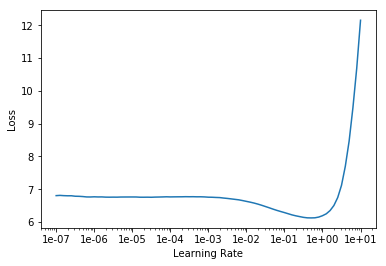

In [0]:
# Find the optimum learning rate
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [0]:
# Download FastAI languae model and fine-tune it
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.442515,5.774093,0.178715,00:13


In [0]:
# Unfreeze all layers of the model for fine-tuning languae model
learn.unfreeze()
learn.fit_one_cycle(cyc_len=20, max_lr=1e-3, moms=(0.8, 0.7)) # 20 epochs for fine-tuning the LM

epoch,train_loss,valid_loss,accuracy,time
0,5.478470,4.871640,0.245121,00:16
1,5.120469,4.701438,0.268001,00:16
2,4.809702,4.488025,0.292841,00:16
3,4.517248,4.321311,0.302806,00:16
4,4.253063,4.210673,0.311448,00:16
5,3.981756,4.158530,0.316837,00:16
6,3.723378,4.161798,0.317682,00:16
7,3.443663,4.186916,0.318559,00:16
8,3.178805,4.230203,0.318064,00:16
9,2.947242,4.315133,0.315880,00:16


In [0]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_csv('./', 'train.csv', vocab=data_lm.train_ds.vocab,min_freq=1, bs=32)
data_clas.save()

In [0]:
# Download classification model and fine-tune it
learn = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


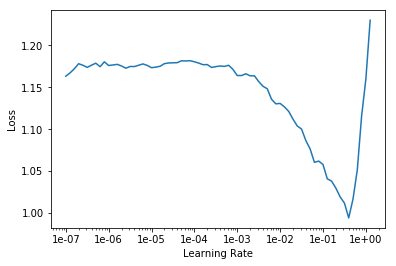

In [0]:
# Find the optimum learning rate for classification model
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [0]:
# Fine-tune all three layers of the model
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.584593,0.506491,0.810821,00:07


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.467572,0.394334,0.827949,00:08


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.417703,0.367703,0.843519,00:13


In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.360205,0.365172,0.842351,00:19
1,0.355474,0.361016,0.845854,00:18
2,0.347964,0.360772,0.848190,00:19
3,0.308000,0.365051,0.848579,00:19
4,0.290818,0.370497,0.860257,00:18
5,0.256869,0.367455,0.850525,00:19
6,0.226278,0.386134,0.852861,00:18
7,0.203242,0.386140,0.850915,00:19
8,0.190900,0.396503,0.849358,00:18
9,0.197482,0.399555,0.852861,00:19


In [0]:
# get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,1595,87,102
1,68,234,1
2,118,2,362


In [0]:
# Evaluate model performance on test data
test = pd.read_csv('test.csv', encoding = "latin-1")
test.head()

,Label,Tweet
0,sexism,RT @JabzzSalam Not sexist but girls on twitter...
1,none,@curdistani @CTFleaMarkets Help from Raqqa to ...
2,none,@dankmtl @PeaceNotHate_ This is too easy. http...
3,none,@Friday13 @DarkSim7 @InvisibleJimBSH @iam8bit ...
4,none,"RT @arna_jane: Kat and Andre, Annie and Lloyd...."


In [0]:
# Apply the predict method to produce our prediction
test['Predicted'] = test['Tweet'].apply(lambda row: str(learn.predict(row)[0]))
test.head()

,Label,Tweet,Predicted
0,sexism,RT @JabzzSalam Not sexist but girls on twitter...,sexism
1,none,@curdistani @CTFleaMarkets Help from Raqqa to ...,none
2,none,@dankmtl @PeaceNotHate_ This is too easy. http...,none
3,none,@Friday13 @DarkSim7 @InvisibleJimBSH @iam8bit ...,sexism
4,none,"RT @arna_jane: Kat and Andre, Annie and Lloyd....",none


In [0]:
# Write the results to csv
test.to_csv("prediction.csv")